#**Facial emotion detection using convolutional nueral networks**

In this project, we will be using a convolutional nueral network on FER-2013 data set to detect emotions from images of people faces.

  FER-2013 has 32,298 grayscaled 48x48 image of faces that is labeled in 7 categories (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral) 

# Imports

First of all, we need to import some basic libraries for out project.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import random
from google.colab import files, drive

We will be using Keras library to code our CNN, the stuff we need from Keras are the followings:

In [ ]:
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Input
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l1, l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.utils import plot_model
from keras.utils import img_to_array

Now we must do some preparation to import our data set. First we upload the data set to google drive and then we exctract it in dataset folder.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir dataset
! cp "/content/drive/MyDrive/DataSet.zip" "/content/Dataset.zip" 
! unzip /content/Dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/archive/train/angry/Training_81541574.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_81541574.jpg  
  inflating: dataset/archive/train/angry/Training_50120123.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_50120123.jpg  
  inflating: dataset/archive/train/angry/Training_60016886.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_60016886.jpg  
  inflating: dataset/archive/train/angry/Training_68690730.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_68690730.jpg  
  inflating: dataset/archive/train/angry/Training_73515932.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_73515932.jpg  
  inflating: dataset/archive/train/angry/Training_32153813.jpg  
  inflating: dataset/__MACOSX/archive/train/angry/._Training_32153813.jpg  
  inflating: dataset/archive/train/angry/Training_57743136.jpg  
  inflating: dataset/__MACOSX/archive/

The data is already spilit into two parts for training and testing. Our path will be: /content/dataset/archive/





# Visualizing data set

Is a good practice to visualize part of our data before we import our training and test datasets so now we count how many image each class has in order to get a better idea about our data set.

We define a count function that will count number of images in each directory.

In [ ]:
def count(path, name):
    dicti = {}
    for expression in os.listdir(path):
        if expression[0] != '.':
            dir = path + expression
            dicti[expression] = len(os.listdir(dir))
    df = pd.DataFrame(dicti, index=[name])
    return df

Now we count our data in the given path and print it out.

In [ ]:
train_dir = '/content/dataset/archive/train/'
test_dir = '/content/dataset/archive/test/'

train_count = count(train_dir, 'train')
test_count = count(test_dir, 'test')
print(train_count)
print(test_count)

       angry  fear  surprise  happy  disgust  neutral   sad
train   3995  4097      3171   7215      436     4965  4830
      angry  fear  surprise  happy  disgust  neutral   sad
test    958  1024       831   1774      111     1233  1247


Afterwards, we visualise our data diversity on a bar plot to get an idea of how our data is spilited.

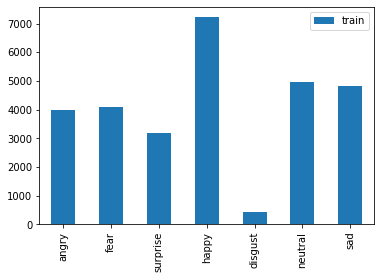

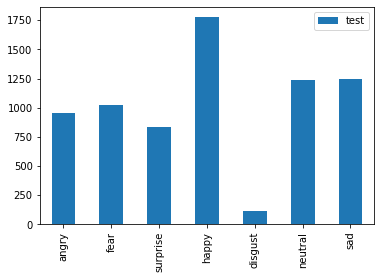

In [ ]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

Analysing the plots, we can see our data is almost evenly spread except for Disgust class so we can be expecting a decent detection for every class except for Disgust class if we train a model on this data set.

Now we load some sample images from each class to check how good our data has been labeled.

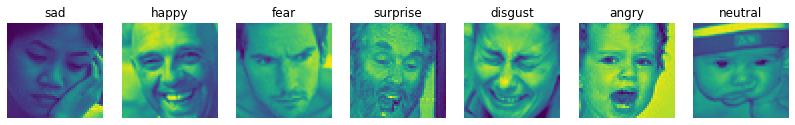

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    if expression[0] != '.':
        img = image.imread((train_dir + expression + '/' + os.listdir(train_dir + expression)[random.randint(0, 435)]))
        plt.subplot(1,7,i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        i += 1
plt.show()

The data seems to be labeled decently, there are some bad labels through the images but overall the labels are related to the images.

Here we define some parameters for our project to use later in the code. these parameters include image size, number of classes, batch size and more.

In [ ]:
image_size = 48
num_classes = 7
num_train = 28709
epochs = 100
batch_size = 256
chk_path = 'check'
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral', 'Surprise']

# Preparing training data set

Now after we visualised our data and got a better idea about how spread it is and how it is labeled, we load our dataset.

Before importing our image, we use ImageDataGenerator in Keras to generate more images from our data set and increase number of datas we have.
> This is called Data Augumentation and has the following beneifts:

*   I increases our datas thus we prevent over fitting
*   Models trained on a small data set will learn the statistical noise in that data set thus we will be improving our accuracy.

 Keras ImageDataGenerator shift, rotates, zooms and etc our current data and changes them a bit and adds them to our data set.

 Here we shift, flip, rescale and zoom on our datas to create our data set. Also loading our data, we have argument "shuffle = True" so each time we run the code, images will be sorted in different orders.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

Now we create our data set.

In [ ]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = True,
                                                color_mode = 'grayscale',
                                                class_mode = 'categorical')

testing_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size = batch_size,
                                                target_size=(image_size, image_size),
                                                shuffle = True,
                                                color_mode = 'grayscale',
                                                class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Neural Networks

Before we continue coding, here are a summary of algorithms we use to create our neural network for recognising emotions. In order to understand algorithms behind our model, we need to understand what Neural Networks are and how they operate.

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.

**Score Function**

The main part of a neural network is the score function. The idea behind it is that we get an image as input, pass that image through a function and the said function gives us an output determining which class the image belongs to. Simplest form of these score functions are linear score functions which is:

> $f(image, w) = w . image + b$

$w$ and $b$ are parameters (weights) that our neural network wants to determine in order to predict images correctly.


**Forward**

Every image can be shown as a matrix, for example a $10*10$ matrix can be shown as $100*1$ matrix. Knowing this and using a linear score function,if we considering $w$'s shape to be $nxm$ where $n$ is number of classes and $m$ is shape of input image after reshaping it to $m*1$, we can calculate $w.image$ and the output matrix will be $n*1$ which will tell us the score our function gave each class for the given image.

**Loss Function**

In neural networks, we define loss functions for each class as correct class score mines class score. This way by minimizing the loss function, we will achive a much more accurate neural network.


We will go in depth about loss functions later in this document but for now we simply define Multi-class SVM loss function as following where $S_y$ is the score for the correct class and $S_j$ is scores for other classes:
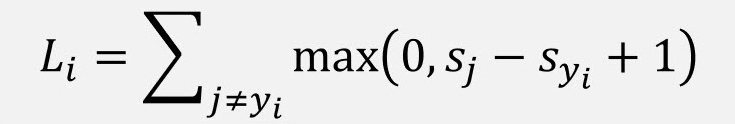

**Soft Max**

Soft Max is the most used loss function. Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Knowing that Softmax is probability based loss function, by trying to maximize correct class score, we automatically minimize other classes scores thus softmax is a better score function than SVM.

**Gradient Descent**

Gradient Descent is a mathematics formula which finds the deepest descent possible (maximum slope) for each given point. As we mentioned before we want to minimize our loss function and Gradient Descent helps us do that. We will go deeper into this topic later.

**Backward Propagation**

In Backward Propagation we compute gradient of the loss function with respect to weights of the network and change those weights accordingly. Back Propagation algorithms go layer by layer, calculating gradient using inputs from our Scor Function and changing weight using the following formula:


> $W_n = W_o - a* $$ \nabla $$_w. L(w)$



**non-Linear Score Functions**

What we said so far is the basis for neural networks. In order to create a NN, we 

**Hidden Layers**

What we said so far is the basis for neural networks. In order to create a neural network, we must use a combination of linaer and non-linear score functions. There are different non-linear score functions like Sigmoid, Tanh and etc but the most recent one is ReLU function. ReLU function calculates maximum between given values. Combination of a linear and non-linear function will create a hidden layer:

> $f = w_2 .max(0, w_1 .x)$

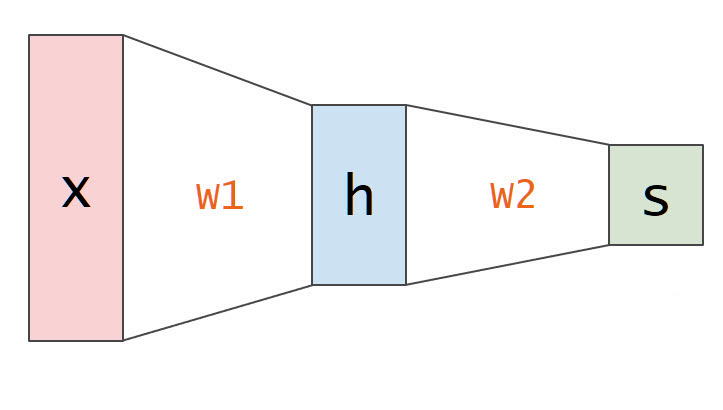



# Convolutional Neural Networks

Convolutional Neural Networks also known as CNN are an advanced form of neural networks that have convolution layers between each hidden layer and using these new type of layers, CNN can be trained to perform way better than a NN model. 

**Convolution Layers**

We add Convolution Layer between our hidden layers and after each Convolution Layer we must add a non-linear layer.

As the name convolution suggests, the layer performs a convolution operation. Covolution Layers add a row and column of 0s around our input matrix (image) and then convolves a filter (smaller matrix) in that matrix creating our output. We call these filters "Kernel".

Kernels get trained over time to recognise stuff, for example if our neural network has five convolution block, the first one gets trained over time to recognise simple stuff like lines but the further we go, each kernel recognises a more advance thing like simple shapes and they keep improving and recognising more complicated objects after each layer.



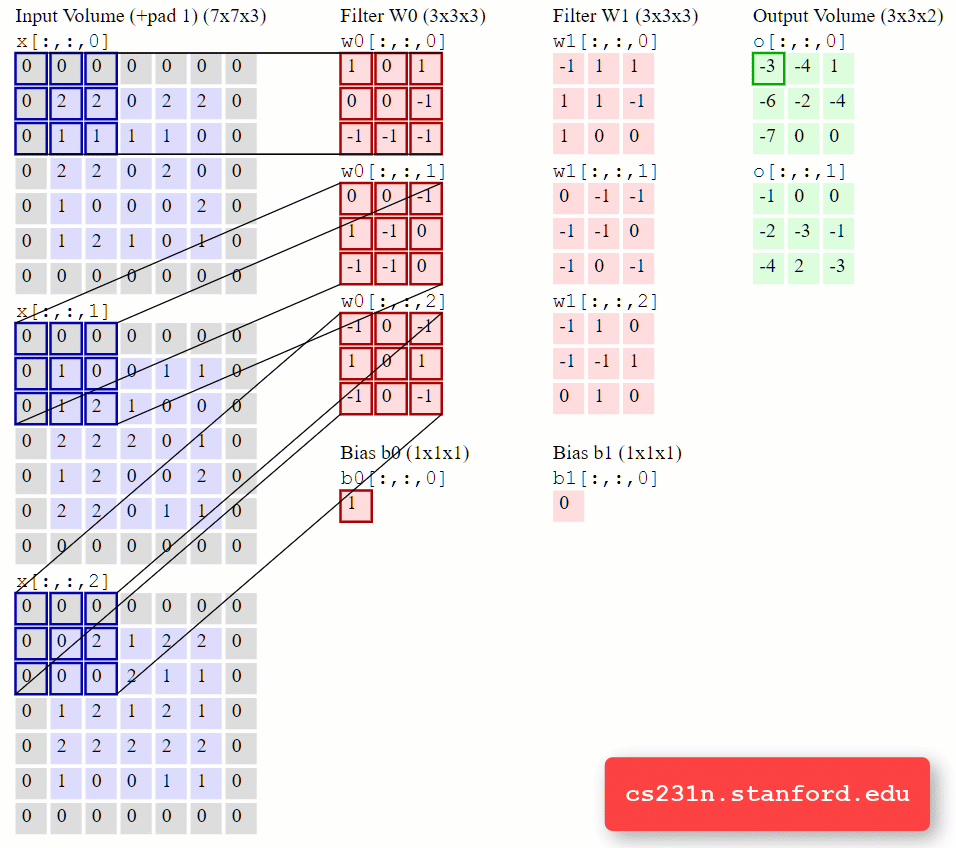

**Convolution Blocks**

Here we call the combination of two convolution layer (with non-linear layer after each) and a Pooling layer a Convolutional Blocks. Of course each block can have more layers.

**Pooling**

We use pooling at the end of each Convolution Block. Pooling helps our model focus on important parts of the given image (matrix). Pooling changes the size of our matrix and makes important pixels bolder. The most commonly used Pooling algorithm is called max pooling.

Max Pooling will choose the maximum number in a smaller area of our image (matrix) and replace that whole part with the maximum:
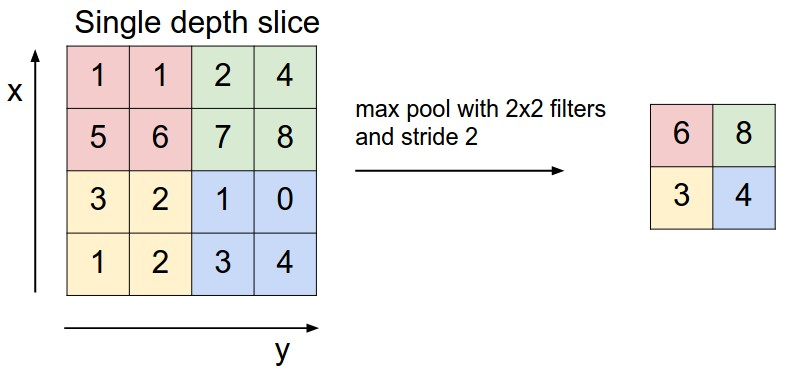

Pooling is used to detect more important futures of each image (matrix).

# Over Fitting and ways to counter it

**Over Fitting**

Adding more hidden layers to our model will improve the results but with doing so, we risk over fitting our model. If a model is over fitted, it does very well predicting training data but it will fail at predicting new datas. In other words, our model corresponds too closely to a set of data and it contains more parameters than can be justified by the data.

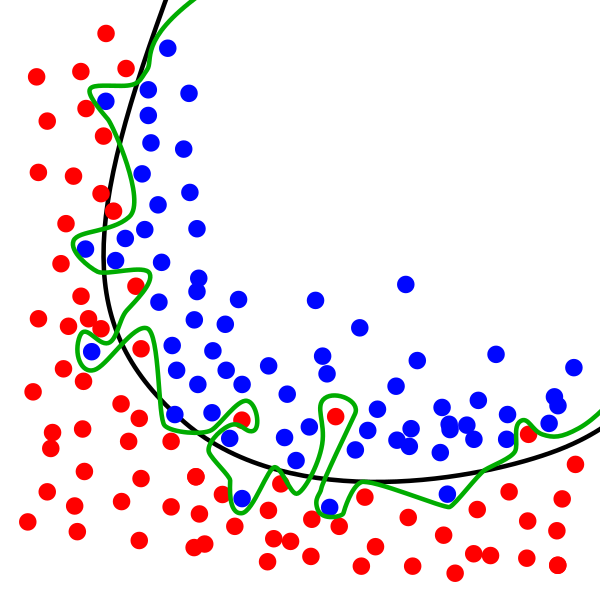

For example as we can see in this image, the green line is an overfitted model, it predicts this specific data set with 100% accuracy but it will have much worse results when predicting other models.




There are multiple ways to counter over fitting our model. The best one is making our data set bigger which we did by Data Augumentation when preparing our data set. Other ways include using different Loss Function, using Dropout, Batch Normalization, Kernel Regularizer and etc. Some of the tactics we used to prevent over fitting will be explained now:

**Dropout**

We use Dropout only when we are training the model. The idea behind it is to randomly ignore a percentage of neurons in a hidden layer and make their output 0. Thus every time we are updating that layer in training, we have a different different view of it's configurations.

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.
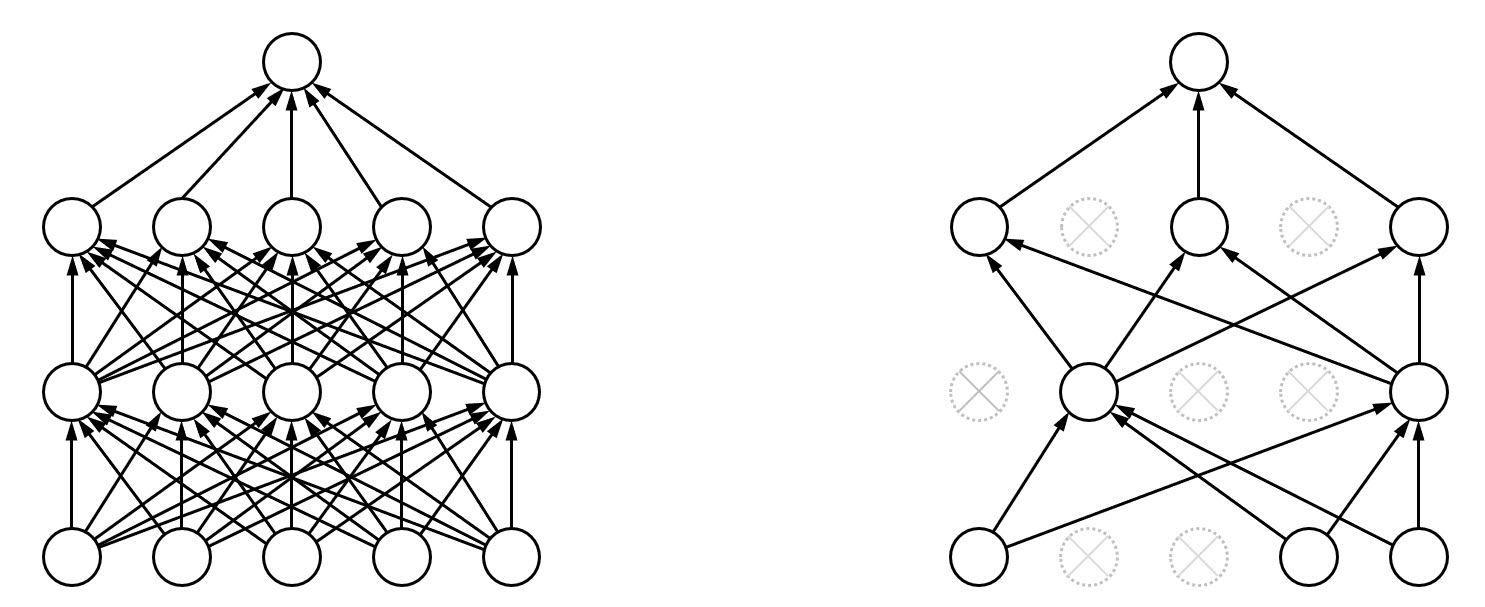

**Batch Normalization**

Batch Normalization improves both training and validation. The idea behind it is giving an equaly devided output to next layer. (std of input = 1)

So basically Batch Normalization is trying to achive fixed distributions of inputs and doing so will decrease the number of Epochs required and overall improve performance of our network.

**Kernel Regularizer**

We add Kernel Regularizer so that our model can perform well on new data, basically we are preventing over fitting. Kernel Regularizer add a penalty factor to each layer which changes weight propagation of layers. There are two types of Kernel Regularizer, L1 and L2 where L1 considers weight of layers and L2 considers square weight of layers.

By adding penalty factors to the weights of the neural network, the neural network weight updation process is quicker with proper weights that can be used for the next updation.

# Loss Function & Optimizer

**Loss Function**

We use loss functions to score our model in classification problems. A loss function is a function that compares the target and predicted output values, measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

A simple example of Loss Fucntion is Multi-class SVM in which we want the score of the correct class mines $delta$ be bigger or equal to score of other classes.

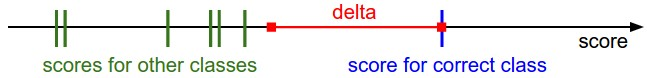

**One-hot Encoding**

Before we continue with loss functions, we need to know about One-hot encoding. In one-hot encoding our score for each class is $1 *$number_of_classes which the correct class gets score of 1 and other classes get score of 0. This type of encoding is required for categorical datas like our data set.

**Categorical Cross-Entropy**

One of the most commonly used loss functions for classification models is Cross-Entropy. Cross-Entropy compeletes Soft-Max algorithm by taking output probability of Soft-Max and measure the distance from correct values and the objective is to make the model output be as close as possible to the desired output.

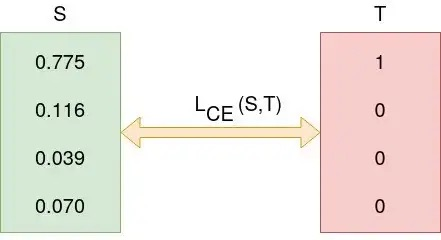

**Optimizer**

Optimizers are algorithms used to change neurons weights and minimize Loss fucntion. The first and most famous of these optimizers are Gradient Decent. Gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function. It calculates that which way the weights should be altered so that the function can reach a minima. Through backpropagation, the loss is transferred from one layer to another and the model’s parameters also known as weights are modified depending on the losses so that the loss can be minimized.

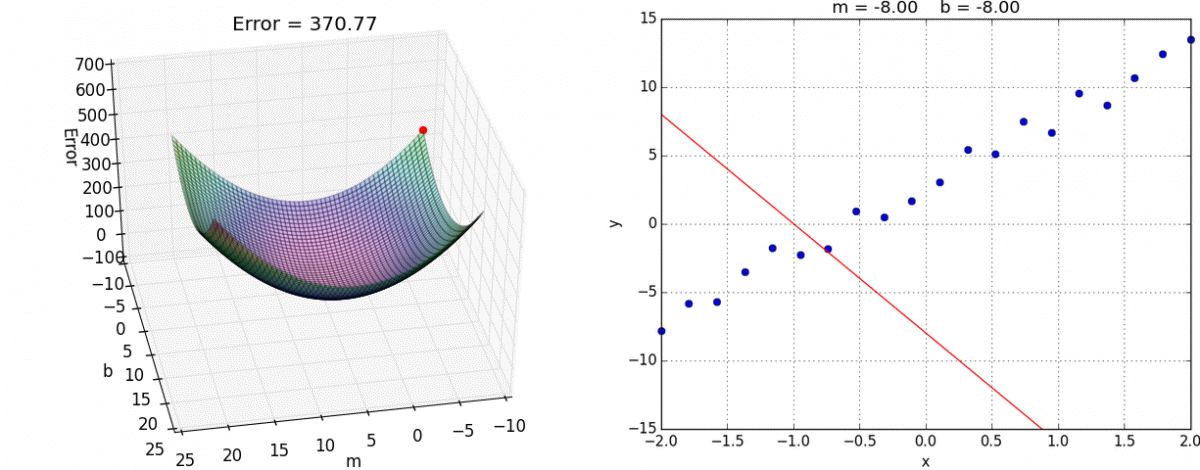

How ever Gradient decent is very slow and requires lots of computational power so now days we use more modern Optimizers.

One of this Optimizers is called Adam which is an extention of stochastic gradient descent and performs really well on almost every data set. In order to understand Adam, we should first understand AdaGrad and RMSProp.


*   Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients.
*   Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight. This means the algorithm does well on online and non-stationary problems.



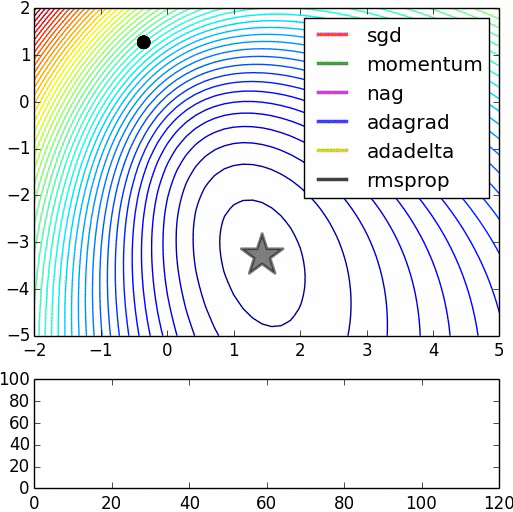

Adam realizes the benefits of both AdaGrad and RMSProp.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

# CNN Model

For this project, we will be using CNN with 2 convolution block, our optimizer will be Adam and our loss function is cross-entropy. We also will use some of the tactics we mentioned earlier to counter over fitting.

In [ ]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same',
                     activation = 'relu',
                     input_shape = (image_size, image_size, 1)))
    model.add(Conv2D(64, kernel_size = (3, 3), 
                     activation = 'relu', 
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                     activation = 'relu',
                     kernel_regularizer = regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size = (3, 3),
                     activation = 'relu', 
                     kernel_regularizer = regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation = 'softmax'))

    optimizer = Adam(lr = 0.0001, decay = 1e-6)
    model.compile(optimizer = optimizer, 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

    return model

Now we can visualise our model to get a better understanding of our neural network

In [ ]:
model = cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


To better understand it, we can plot the model.

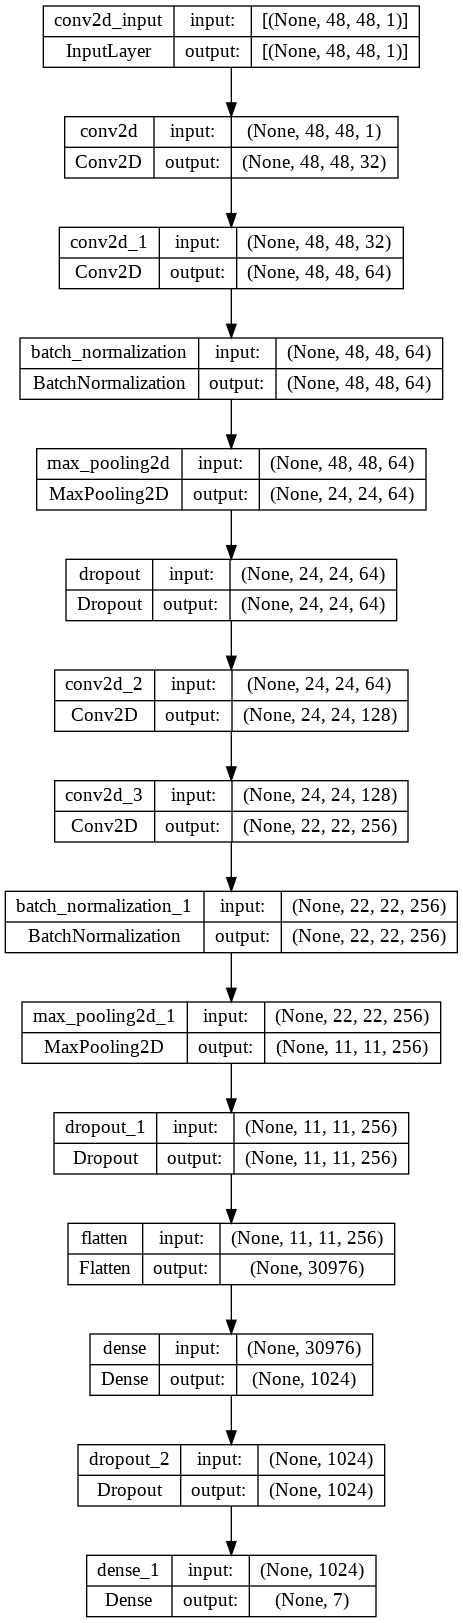

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)


# Training the model

After creating our model, we now fit our training data and start training our neural network.

Here we add two additional parameters, checkpoints and learning rate reduction.

Using checkpoints, we save the best result after each itteration and also it's helpfull if our system crashes.

In [ ]:
checkpoint = ModelCheckpoint(filepath = chk_path,
                            save_best_only = True,
                            verbose = 1,
                            mode = 'min',
                            moniter = 'val_loss')

The logic behind LR Decay is that our loss function gets closer to the minimum point by after each itteration, so by making our LR smaller, we will be taking smaller steps each itteration and this will give us a better minimum point.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                            factor = 0.2,
                            patience = 6,
                            verbose = 1,
                            min_delta = 0.0001)

Now we start the training and use training_set for our training and testing_set for validation.

In [ ]:
callbacks = [checkpoint, reduce_lr]

result = model.fit(x = training_set,
             validation_data = testing_set,
             steps_per_epoch = num_train/batch_size,
             verbose = 1,
             callbacks = callbacks,
             epochs = epochs)

Epoch 1/100
113/112 [==============================] - ETA: 0s - loss: 4.7722 - accuracy: 0.2452
Epoch 1: val_loss improved from inf to 5.37947, saving model to check


112/112 [==============================] - 31s 266ms/step - loss: 4.7722 - accuracy: 0.2452 - val_loss: 5.3795 - val_accuracy: 0.1427 - lr: 1.0000e-04
Epoch 2/100
113/112 [==============================] - ETA: 0s - loss: 3.9810 - accuracy: 0.2950
Epoch 2: val_loss did not improve from 5.37947
112/112 [==============================] - 27s 239ms/step - loss: 3.9810 - accuracy: 0.2950 - val_loss: 6.8549 - val_accuracy: 0.1427 - lr: 1.0000e-04
Epoch 3/100
113/112 [==============================] - ETA: 0s - loss: 3.6972 - accuracy: 0.3161
Epoch 3: val_loss did not improve from 5.37947
112/112 [==============================] - 26s 228ms/step - loss: 3.6972 - accuracy: 0.3161 - val_loss: 6.1603 - val_accuracy: 0.1931 - lr: 1.0000e-04
Epoch 4/100
113/112 [==============================] - ETA: 0s - loss: 3.4245 - accuracy: 0.3341
Epoch 4: val_loss did not improve from 5.37947
112/112 [==============================] - 25s 225ms/step - loss: 3.4245 - accuracy: 0.3341 - val_loss: 5.9214 - va

112/112 [==============================] - 28s 254ms/step - loss: 3.1725 - accuracy: 0.3513 - val_loss: 4.5659 - val_accuracy: 0.2952 - lr: 1.0000e-04
Epoch 6/100
113/112 [==============================] - ETA: 0s - loss: 2.9414 - accuracy: 0.3788
Epoch 6: val_loss improved from 4.56590 to 3.15025, saving model to check


112/112 [==============================] - 28s 251ms/step - loss: 2.9414 - accuracy: 0.3788 - val_loss: 3.1502 - val_accuracy: 0.3877 - lr: 1.0000e-04
Epoch 7/100
113/112 [==============================] - ETA: 0s - loss: 2.7286 - accuracy: 0.3998
Epoch 7: val_loss improved from 3.15025 to 2.70579, saving model to check


112/112 [==============================] - 30s 265ms/step - loss: 2.7286 - accuracy: 0.3998 - val_loss: 2.7058 - val_accuracy: 0.4296 - lr: 1.0000e-04
Epoch 8/100
113/112 [==============================] - ETA: 0s - loss: 2.5546 - accuracy: 0.4156
Epoch 8: val_loss improved from 2.70579 to 2.37442, saving model to check


112/112 [==============================] - 28s 252ms/step - loss: 2.5546 - accuracy: 0.4156 - val_loss: 2.3744 - val_accuracy: 0.4696 - lr: 1.0000e-04
Epoch 9/100
113/112 [==============================] - ETA: 0s - loss: 2.3900 - accuracy: 0.4368
Epoch 9: val_loss improved from 2.37442 to 2.29990, saving model to check


112/112 [==============================] - 28s 251ms/step - loss: 2.3900 - accuracy: 0.4368 - val_loss: 2.2999 - val_accuracy: 0.4716 - lr: 1.0000e-04
Epoch 10/100
113/112 [==============================] - ETA: 0s - loss: 2.2437 - accuracy: 0.4472
Epoch 10: val_loss improved from 2.29990 to 2.14092, saving model to check


112/112 [==============================] - 28s 252ms/step - loss: 2.2437 - accuracy: 0.4472 - val_loss: 2.1409 - val_accuracy: 0.4916 - lr: 1.0000e-04
Epoch 11/100
113/112 [==============================] - ETA: 0s - loss: 2.1221 - accuracy: 0.4640
Epoch 11: val_loss improved from 2.14092 to 1.94624, saving model to check


112/112 [==============================] - 30s 264ms/step - loss: 2.1221 - accuracy: 0.4640 - val_loss: 1.9462 - val_accuracy: 0.5166 - lr: 1.0000e-04
Epoch 12/100
113/112 [==============================] - ETA: 0s - loss: 2.0087 - accuracy: 0.4766
Epoch 12: val_loss improved from 1.94624 to 1.84173, saving model to check


112/112 [==============================] - 28s 253ms/step - loss: 2.0087 - accuracy: 0.4766 - val_loss: 1.8417 - val_accuracy: 0.5245 - lr: 1.0000e-04
Epoch 13/100
113/112 [==============================] - ETA: 0s - loss: 1.9115 - accuracy: 0.4874
Epoch 13: val_loss improved from 1.84173 to 1.78962, saving model to check


112/112 [==============================] - 28s 252ms/step - loss: 1.9115 - accuracy: 0.4874 - val_loss: 1.7896 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 14/100
113/112 [==============================] - ETA: 0s - loss: 1.8253 - accuracy: 0.5001
Epoch 14: val_loss improved from 1.78962 to 1.71279, saving model to check


112/112 [==============================] - 28s 251ms/step - loss: 1.8253 - accuracy: 0.5001 - val_loss: 1.7128 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 15/100
113/112 [==============================] - ETA: 0s - loss: 1.7428 - accuracy: 0.5103
Epoch 15: val_loss improved from 1.71279 to 1.65661, saving model to check


112/112 [==============================] - 28s 248ms/step - loss: 1.7428 - accuracy: 0.5103 - val_loss: 1.6566 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 16/100
113/112 [==============================] - ETA: 0s - loss: 1.6727 - accuracy: 0.5209
Epoch 16: val_loss improved from 1.65661 to 1.60322, saving model to check


112/112 [==============================] - 29s 257ms/step - loss: 1.6727 - accuracy: 0.5209 - val_loss: 1.6032 - val_accuracy: 0.5428 - lr: 1.0000e-04
Epoch 17/100
113/112 [==============================] - ETA: 0s - loss: 1.6177 - accuracy: 0.5262
Epoch 17: val_loss improved from 1.60322 to 1.50370, saving model to check


112/112 [==============================] - 27s 243ms/step - loss: 1.6177 - accuracy: 0.5262 - val_loss: 1.5037 - val_accuracy: 0.5638 - lr: 1.0000e-04
Epoch 18/100
113/112 [==============================] - ETA: 0s - loss: 1.5563 - accuracy: 0.5391
Epoch 18: val_loss improved from 1.50370 to 1.45728, saving model to check


112/112 [==============================] - 28s 246ms/step - loss: 1.5563 - accuracy: 0.5391 - val_loss: 1.4573 - val_accuracy: 0.5630 - lr: 1.0000e-04
Epoch 19/100
113/112 [==============================] - ETA: 0s - loss: 1.5077 - accuracy: 0.5416
Epoch 19: val_loss improved from 1.45728 to 1.44940, saving model to check


112/112 [==============================] - 28s 245ms/step - loss: 1.5077 - accuracy: 0.5416 - val_loss: 1.4494 - val_accuracy: 0.5624 - lr: 1.0000e-04
Epoch 20/100
113/112 [==============================] - ETA: 0s - loss: 1.4631 - accuracy: 0.5500
Epoch 20: val_loss did not improve from 1.44940
112/112 [==============================] - 26s 235ms/step - loss: 1.4631 - accuracy: 0.5500 - val_loss: 1.4720 - val_accuracy: 0.5435 - lr: 1.0000e-04
Epoch 21/100
113/112 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.5549
Epoch 21: val_loss improved from 1.44940 to 1.33616, saving model to check


112/112 [==============================] - 28s 246ms/step - loss: 1.4280 - accuracy: 0.5549 - val_loss: 1.3362 - val_accuracy: 0.5854 - lr: 1.0000e-04
Epoch 22/100
113/112 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.5663
Epoch 22: val_loss improved from 1.33616 to 1.29889, saving model to check


112/112 [==============================] - 28s 248ms/step - loss: 1.3795 - accuracy: 0.5663 - val_loss: 1.2989 - val_accuracy: 0.5935 - lr: 1.0000e-04
Epoch 23/100
113/112 [==============================] - ETA: 0s - loss: 1.3471 - accuracy: 0.5744
Epoch 23: val_loss did not improve from 1.29889
112/112 [==============================] - 25s 222ms/step - loss: 1.3471 - accuracy: 0.5744 - val_loss: 1.3041 - val_accuracy: 0.5847 - lr: 1.0000e-04
Epoch 24/100
113/112 [==============================] - ETA: 0s - loss: 1.3133 - accuracy: 0.5766
Epoch 24: val_loss improved from 1.29889 to 1.29470, saving model to check


112/112 [==============================] - 28s 250ms/step - loss: 1.3133 - accuracy: 0.5766 - val_loss: 1.2947 - val_accuracy: 0.5837 - lr: 1.0000e-04
Epoch 25/100
113/112 [==============================] - ETA: 0s - loss: 1.2909 - accuracy: 0.5824
Epoch 25: val_loss improved from 1.29470 to 1.26977, saving model to check


112/112 [==============================] - 28s 245ms/step - loss: 1.2909 - accuracy: 0.5824 - val_loss: 1.2698 - val_accuracy: 0.5864 - lr: 1.0000e-04
Epoch 26/100
113/112 [==============================] - ETA: 0s - loss: 1.2591 - accuracy: 0.5918
Epoch 26: val_loss improved from 1.26977 to 1.21826, saving model to check


112/112 [==============================] - 29s 260ms/step - loss: 1.2591 - accuracy: 0.5918 - val_loss: 1.2183 - val_accuracy: 0.6038 - lr: 1.0000e-04
Epoch 27/100
113/112 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.5947
Epoch 27: val_loss did not improve from 1.21826
112/112 [==============================] - 25s 222ms/step - loss: 1.2408 - accuracy: 0.5947 - val_loss: 1.2272 - val_accuracy: 0.5986 - lr: 1.0000e-04
Epoch 28/100
113/112 [==============================] - ETA: 0s - loss: 1.2170 - accuracy: 0.6000
Epoch 28: val_loss improved from 1.21826 to 1.19836, saving model to check


112/112 [==============================] - 29s 258ms/step - loss: 1.2170 - accuracy: 0.6000 - val_loss: 1.1984 - val_accuracy: 0.6088 - lr: 1.0000e-04
Epoch 29/100
113/112 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.6059
Epoch 29: val_loss improved from 1.19836 to 1.16591, saving model to check


112/112 [==============================] - 28s 248ms/step - loss: 1.1901 - accuracy: 0.6059 - val_loss: 1.1659 - val_accuracy: 0.6149 - lr: 1.0000e-04
Epoch 30/100
113/112 [==============================] - ETA: 0s - loss: 1.1695 - accuracy: 0.6111
Epoch 30: val_loss did not improve from 1.16591
112/112 [==============================] - 25s 222ms/step - loss: 1.1695 - accuracy: 0.6111 - val_loss: 1.2611 - val_accuracy: 0.5855 - lr: 1.0000e-04
Epoch 31/100
113/112 [==============================] - ETA: 0s - loss: 1.1484 - accuracy: 0.6175
Epoch 31: val_loss improved from 1.16591 to 1.15063, saving model to check


112/112 [==============================] - 28s 249ms/step - loss: 1.1484 - accuracy: 0.6175 - val_loss: 1.1506 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 32/100
113/112 [==============================] - ETA: 0s - loss: 1.1356 - accuracy: 0.6208
Epoch 32: val_loss improved from 1.15063 to 1.14152, saving model to check


112/112 [==============================] - 28s 247ms/step - loss: 1.1356 - accuracy: 0.6208 - val_loss: 1.1415 - val_accuracy: 0.6201 - lr: 1.0000e-04
Epoch 33/100
113/112 [==============================] - ETA: 0s - loss: 1.1127 - accuracy: 0.6288
Epoch 33: val_loss improved from 1.14152 to 1.12034, saving model to check


112/112 [==============================] - 29s 260ms/step - loss: 1.1127 - accuracy: 0.6288 - val_loss: 1.1203 - val_accuracy: 0.6180 - lr: 1.0000e-04
Epoch 34/100
113/112 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.6309
Epoch 34: val_loss did not improve from 1.12034
112/112 [==============================] - 28s 251ms/step - loss: 1.1000 - accuracy: 0.6309 - val_loss: 1.1242 - val_accuracy: 0.6259 - lr: 1.0000e-04
Epoch 35/100
113/112 [==============================] - ETA: 0s - loss: 1.0842 - accuracy: 0.6350
Epoch 35: val_loss improved from 1.12034 to 1.09248, saving model to check


112/112 [==============================] - 33s 300ms/step - loss: 1.0842 - accuracy: 0.6350 - val_loss: 1.0925 - val_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 36/100
113/112 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.6421
Epoch 36: val_loss did not improve from 1.09248
112/112 [==============================] - 30s 266ms/step - loss: 1.0665 - accuracy: 0.6421 - val_loss: 1.1072 - val_accuracy: 0.6264 - lr: 1.0000e-04
Epoch 37/100
113/112 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.6437
Epoch 37: val_loss improved from 1.09248 to 1.07656, saving model to check


112/112 [==============================] - 28s 248ms/step - loss: 1.0534 - accuracy: 0.6437 - val_loss: 1.0766 - val_accuracy: 0.6420 - lr: 1.0000e-04
Epoch 38/100
113/112 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.6516
Epoch 38: val_loss improved from 1.07656 to 1.07338, saving model to check


112/112 [==============================] - 30s 265ms/step - loss: 1.0386 - accuracy: 0.6516 - val_loss: 1.0734 - val_accuracy: 0.6393 - lr: 1.0000e-04
Epoch 39/100
113/112 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.6546
Epoch 39: val_loss improved from 1.07338 to 1.07278, saving model to check


112/112 [==============================] - 29s 254ms/step - loss: 1.0234 - accuracy: 0.6546 - val_loss: 1.0728 - val_accuracy: 0.6396 - lr: 1.0000e-04
Epoch 40/100
113/112 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.6561
Epoch 40: val_loss did not improve from 1.07278
112/112 [==============================] - 26s 229ms/step - loss: 1.0131 - accuracy: 0.6561 - val_loss: 1.1071 - val_accuracy: 0.6258 - lr: 1.0000e-04
Epoch 41/100
113/112 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.6623
Epoch 41: val_loss improved from 1.07278 to 1.07011, saving model to check


112/112 [==============================] - 28s 252ms/step - loss: 0.9963 - accuracy: 0.6623 - val_loss: 1.0701 - val_accuracy: 0.6358 - lr: 1.0000e-04
Epoch 42/100
113/112 [==============================] - ETA: 0s - loss: 0.9868 - accuracy: 0.6669
Epoch 42: val_loss did not improve from 1.07011
112/112 [==============================] - 27s 237ms/step - loss: 0.9868 - accuracy: 0.6669 - val_loss: 1.0760 - val_accuracy: 0.6347 - lr: 1.0000e-04
Epoch 43/100
113/112 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.6741
Epoch 43: val_loss improved from 1.07011 to 1.06004, saving model to check


112/112 [==============================] - 29s 262ms/step - loss: 0.9744 - accuracy: 0.6741 - val_loss: 1.0600 - val_accuracy: 0.6467 - lr: 1.0000e-04
Epoch 44/100
113/112 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.6760
Epoch 44: val_loss did not improve from 1.06004
112/112 [==============================] - 25s 224ms/step - loss: 0.9677 - accuracy: 0.6760 - val_loss: 1.1023 - val_accuracy: 0.6381 - lr: 1.0000e-04
Epoch 45/100
113/112 [==============================] - ETA: 0s - loss: 0.9522 - accuracy: 0.6812
Epoch 45: val_loss improved from 1.06004 to 1.05521, saving model to check


112/112 [==============================] - 30s 270ms/step - loss: 0.9522 - accuracy: 0.6812 - val_loss: 1.0552 - val_accuracy: 0.6404 - lr: 1.0000e-04
Epoch 46/100
113/112 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.6873
Epoch 46: val_loss did not improve from 1.05521
112/112 [==============================] - 29s 255ms/step - loss: 0.9330 - accuracy: 0.6873 - val_loss: 1.0666 - val_accuracy: 0.6459 - lr: 1.0000e-04
Epoch 47/100
113/112 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.6879
Epoch 47: val_loss did not improve from 1.05521
112/112 [==============================] - 26s 227ms/step - loss: 0.9337 - accuracy: 0.6879 - val_loss: 1.0708 - val_accuracy: 0.6478 - lr: 1.0000e-04
Epoch 48/100
113/112 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.6941
Epoch 48: val_loss did not improve from 1.05521
112/112 [==============================] - 25s 225ms/step - loss: 0.9159 - accuracy: 0.6941 - val_loss: 1.073

112/112 [==============================] - 29s 254ms/step - loss: 0.9054 - accuracy: 0.6963 - val_loss: 1.0417 - val_accuracy: 0.6559 - lr: 1.0000e-04
Epoch 50/100
113/112 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.6997
Epoch 50: val_loss did not improve from 1.04170
112/112 [==============================] - 26s 227ms/step - loss: 0.9016 - accuracy: 0.6997 - val_loss: 1.0451 - val_accuracy: 0.6478 - lr: 1.0000e-04
Epoch 51/100
113/112 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.7038
Epoch 51: val_loss did not improve from 1.04170
112/112 [==============================] - 27s 238ms/step - loss: 0.8858 - accuracy: 0.7038 - val_loss: 1.0722 - val_accuracy: 0.6496 - lr: 1.0000e-04
Epoch 52/100
113/112 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.7077
Epoch 52: val_loss improved from 1.04170 to 1.02918, saving model to check


112/112 [==============================] - 29s 259ms/step - loss: 0.8781 - accuracy: 0.7077 - val_loss: 1.0292 - val_accuracy: 0.6565 - lr: 1.0000e-04
Epoch 53/100
113/112 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.7148
Epoch 53: val_loss did not improve from 1.02918
112/112 [==============================] - 27s 238ms/step - loss: 0.8576 - accuracy: 0.7148 - val_loss: 1.0569 - val_accuracy: 0.6545 - lr: 1.0000e-04
Epoch 54/100
113/112 [==============================] - ETA: 0s - loss: 0.8534 - accuracy: 0.7186
Epoch 54: val_loss did not improve from 1.02918
112/112 [==============================] - 26s 228ms/step - loss: 0.8534 - accuracy: 0.7186 - val_loss: 1.0634 - val_accuracy: 0.6567 - lr: 1.0000e-04
Epoch 55/100
113/112 [==============================] - ETA: 0s - loss: 0.8478 - accuracy: 0.7185
Epoch 55: val_loss did not improve from 1.02918
112/112 [==============================] - 25s 226ms/step - loss: 0.8478 - accuracy: 0.7185 - val_loss: 1.070

112/112 [==============================] - 29s 262ms/step - loss: 0.8419 - accuracy: 0.7230 - val_loss: 1.0264 - val_accuracy: 0.6627 - lr: 1.0000e-04
Epoch 57/100
113/112 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.7252
Epoch 57: val_loss did not improve from 1.02644
112/112 [==============================] - 25s 226ms/step - loss: 0.8244 - accuracy: 0.7252 - val_loss: 1.0427 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 58/100
113/112 [==============================] - ETA: 0s - loss: 0.8193 - accuracy: 0.7281
Epoch 58: val_loss did not improve from 1.02644
112/112 [==============================] - 27s 236ms/step - loss: 0.8193 - accuracy: 0.7281 - val_loss: 1.0415 - val_accuracy: 0.6555 - lr: 1.0000e-04
Epoch 59/100
113/112 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.7329
Epoch 59: val_loss did not improve from 1.02644
112/112 [==============================] - 25s 223ms/step - loss: 0.8137 - accuracy: 0.7329 - val_loss: 1.049

112/112 [==============================] - 29s 263ms/step - loss: 0.7325 - accuracy: 0.7618 - val_loss: 1.0203 - val_accuracy: 0.6750 - lr: 2.0000e-05
Epoch 65/100
113/112 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.7665
Epoch 65: val_loss improved from 1.02027 to 1.01713, saving model to check


112/112 [==============================] - 28s 247ms/step - loss: 0.7276 - accuracy: 0.7665 - val_loss: 1.0171 - val_accuracy: 0.6750 - lr: 2.0000e-05
Epoch 66/100
113/112 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7705
Epoch 66: val_loss did not improve from 1.01713
112/112 [==============================] - 27s 239ms/step - loss: 0.7137 - accuracy: 0.7705 - val_loss: 1.0191 - val_accuracy: 0.6783 - lr: 2.0000e-05
Epoch 67/100
113/112 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.7711
Epoch 67: val_loss did not improve from 1.01713
112/112 [==============================] - 26s 230ms/step - loss: 0.7108 - accuracy: 0.7711 - val_loss: 1.0261 - val_accuracy: 0.6778 - lr: 2.0000e-05
Epoch 68/100
113/112 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.7754
Epoch 68: val_loss did not improve from 1.01713
112/112 [==============================] - 25s 225ms/step - loss: 0.7005 - accuracy: 0.7754 - val_loss: 1.019

112/112 [==============================] - 28s 247ms/step - loss: 0.6932 - accuracy: 0.7776 - val_loss: 1.0144 - val_accuracy: 0.6773 - lr: 2.0000e-05
Epoch 71/100
113/112 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.7810
Epoch 71: val_loss did not improve from 1.01437
112/112 [==============================] - 26s 235ms/step - loss: 0.6881 - accuracy: 0.7810 - val_loss: 1.0166 - val_accuracy: 0.6776 - lr: 2.0000e-05
Epoch 72/100
113/112 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.7840
Epoch 72: val_loss did not improve from 1.01437
112/112 [==============================] - 26s 233ms/step - loss: 0.6792 - accuracy: 0.7840 - val_loss: 1.0167 - val_accuracy: 0.6773 - lr: 2.0000e-05
Epoch 73/100
113/112 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.7856
Epoch 73: val_loss improved from 1.01437 to 1.01157, saving model to check


112/112 [==============================] - 28s 251ms/step - loss: 0.6749 - accuracy: 0.7856 - val_loss: 1.0116 - val_accuracy: 0.6772 - lr: 2.0000e-05
Epoch 74/100
113/112 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7817
Epoch 74: val_loss did not improve from 1.01157
112/112 [==============================] - 26s 232ms/step - loss: 0.6745 - accuracy: 0.7817 - val_loss: 1.0220 - val_accuracy: 0.6765 - lr: 2.0000e-05
Epoch 75/100
113/112 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7861
Epoch 75: val_loss did not improve from 1.01157
112/112 [==============================] - 25s 224ms/step - loss: 0.6682 - accuracy: 0.7861 - val_loss: 1.0327 - val_accuracy: 0.6779 - lr: 2.0000e-05
Epoch 76/100
113/112 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7861
Epoch 76: val_loss did not improve from 1.01157
112/112 [==============================] - 26s 231ms/step - loss: 0.6665 - accuracy: 0.7861 - val_loss: 1.011

Now that the training is compelete, we evalute the model and visualize it on a plot to show how our accurrecy improves after each Epoch.

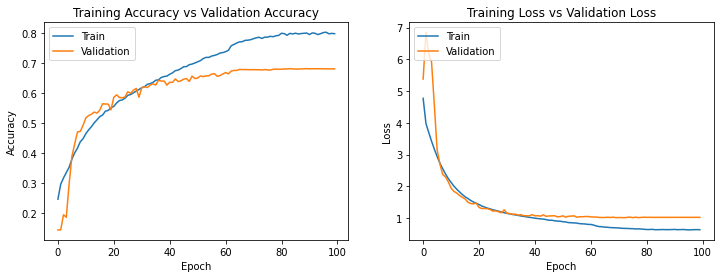

In [ ]:
fig , ax = plt.subplots(1, 2)
train_acc = result.history['accuracy']
train_loss = result.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(result.history['accuracy'])
ax[0].plot(result.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc = 'upper left')

ax[1].plot(result.history['loss'])
ax[1].plot(result.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

Now to decide if we want to save the model or not.

In [ ]:
model.save('cnn_emotion')
!cp -av "/content/cnn_emotion_4" "/content/drive/MyDrive/"

'/content/cnn_emotion_4' -> '/content/drive/MyDrive/cnn_emotion_4'
'/content/cnn_emotion_4/variables' -> '/content/drive/MyDrive/cnn_emotion_4/variables'
'/content/cnn_emotion_4/variables/variables.index' -> '/content/drive/MyDrive/cnn_emotion_4/variables/variables.index'
'/content/cnn_emotion_4/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/cnn_emotion_4/variables/variables.data-00000-of-00001'
'/content/cnn_emotion_4/assets' -> '/content/drive/MyDrive/cnn_emotion_4/assets'
'/content/cnn_emotion_4/saved_model.pb' -> '/content/drive/MyDrive/cnn_emotion_4/saved_model.pb'
'/content/cnn_emotion_4/keras_metadata.pb' -> '/content/drive/MyDrive/cnn_emotion_4/keras_metadata.pb'


# Showing results

Now that we are done training our model, we load it and give our model some images to see how it works.

Since we have a pre trained model with 72% accuracy, we load that from google drive and test it out.

In [ ]:
drive.mount('/content/drive')
! cp -av "/content/drive/MyDrive/cnn_emotion.zim" "/content/"
! mkdir cnn_emotion
! unzip /content/cnn_emotion.zip

'/content/drive/MyDrive/cnn_emotion_4' -> '/content/cnn_emotion_4'
'/content/drive/MyDrive/cnn_emotion_4/assets' -> '/content/cnn_emotion_4/assets'
'/content/drive/MyDrive/cnn_emotion_4/keras_metadata.pb' -> '/content/cnn_emotion_4/keras_metadata.pb'
'/content/drive/MyDrive/cnn_emotion_4/saved_model.pb' -> '/content/cnn_emotion_4/saved_model.pb'
'/content/drive/MyDrive/cnn_emotion_4/variables' -> '/content/cnn_emotion_4/variables'
'/content/drive/MyDrive/cnn_emotion_4/variables/variables.index' -> '/content/cnn_emotion_4/variables/variables.index'
'/content/drive/MyDrive/cnn_emotion_4/variables/variables.data-00000-of-00001' -> '/content/cnn_emotion_4/variables/variables.data-00000-of-00001'


In [ ]:
model = load_model("cnn_emotion")

1/1 [==============================] - 0s 115ms/step


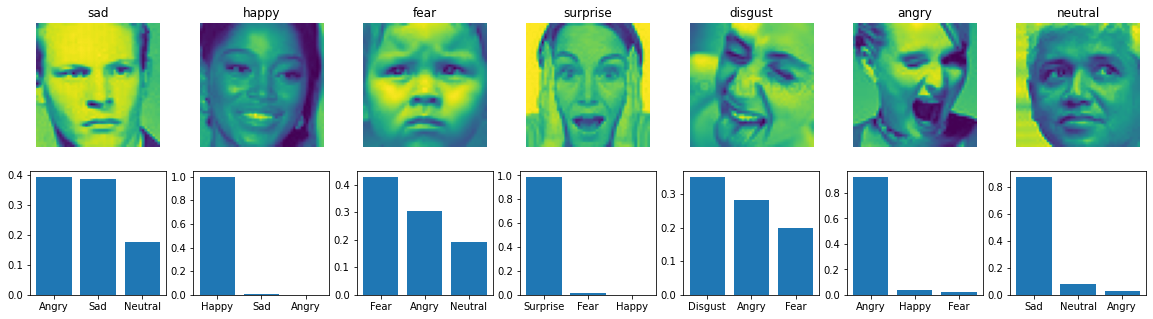

In [ ]:
plt.figure(figsize=(20,5))
i = 1
for expression in os.listdir(test_dir):
    if expression[0] != '.':
        img = image.imread((test_dir + expression + '/' + os.listdir(test_dir + expression)[random.randint(0, 111)]))
        plt.subplot(2,7,i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        imag = img
        img = img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        img /= 255
        p = model.predict(img)
        p = p[0]
        pred_label = np.argsort(-p)[:3]
        pred_prob = [p[l] for l in pred_label]
        pred_label = [class_names[l] for l in pred_label]
        plt.subplot(2, 7, i+7)
        plt.bar(range(3), pred_prob)
        plt.xticks(range(3), pred_label)
        i += 1
plt.show()